In [2]:
# machine learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import shap
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Visualization 
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import math
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Loading Bid Data

In [62]:
# Importing data set 
bid_data_df = pd.read_excel('Bid_Data_Expanded.xlsx',sheet_name="Bid Data",header=0) 
bid_data_df.head()

,Customer ID,Material Number,Product Family,Annual units,Monthly units,Contract Status,Customer Supply Start date,Bid Submitted Date,Bid Submitted Date.1,Bid Submitted Month,...,Failure to Supply Rate (FTS) per unit,Failure to Supply - Weighted Avg Exposure (2018),Failure to Supply - Weighted Avg Exposure (2019),Forecast,Launch Date,Launch Date Serial,Supply Quantity (Replenishment),Market Share %,Number of Competitors,WAC Price
0,1001517.0,51025.0,381.0,65617,5468.000000,NEW BUSINESS,2017-01-10 00:00:00,2017-01-01,42736.0,1.0,...,not available,NaN,NaN,905.0,NaT,0.0,NaN,NaN,NaN,NaN
1,1001517.0,51024.0,381.0,54765,4564.000000,NEW BUSINESS,2017-01-10 00:00:00,2017-01-01,42736.0,1.0,...,not available,NaN,NaN,1400.0,NaT,0.0,NaN,NaN,NaN,NaN
2,1001517.0,48912.0,381.0,121861,10155.000000,NEW BUSINESS,2017-01-10 00:00:00,2017-01-01,42736.0,1.0,...,not available,NaN,NaN,1043.0,NaT,0.0,NaN,NaN,NaN,NaN
3,1001517.0,48914.0,381.0,101706,8476.000000,NEW BUSINESS,2017-01-10 00:00:00,2017-01-01,42736.0,1.0,...,not available,NaN,NaN,2008.0,NaT,41030.0,NaN,NaN,NaN,NaN
4,1000813.0,59481.0,322.0,4190,349.166667,NEW BUSINESS,2017-02-04 00:00:00,2017-01-01,42736.0,1.0,...,not available,2.569672,0.225163,522.0,2012-05-01,41030.0,1706.0,NaN,NaN,NaN


In [4]:
bid_data_df.dtypes

Customer ID                                                float64
Material Number                                            float64
Product Family                                             float64
Annual units                                                object
Monthly units                                              float64
Contract Status                                             object
Customer Supply Start date                                  object
Bid Submitted Date                                  datetime64[ns]
Bid Submitted Date.1                                       float64
Bid Submitted Month                                        float64
Bid Submitted Year                                         float64
Apotex Response                                             object
Customer Response                                           object
Failure to Supply Rate (FTS) per unit                       object
Failure to Supply - Weighted Avg Exposure (2018)           flo

## Data Fixes
There are several issues with the current data set that need to be addressed
- Customer Supply Start Date needs to be fixed (solved)
- Annual Units needs to be a float (solved)
- Contract Status needs to be 1-hot encoded
- Bid Submitted Date needs to be fixed (solved)
- Bid Submitted Month needs to be 1-hot encoded (solved)
- Apotex Response needs to be 1-hot encoded (solved)
- Customer Response we need to drop the empty rows (solved)
- Figure out what to do for FTS columns (solved)
- Figure out what to do with other columns (solved)

In [5]:
# Remove all the rows where the 'Customer Supply Start date' is NaN
# All the other rows in this case are also NaN (probably some excel stuff)
bid_data_df = bid_data_df.loc[~bid_data_df['Customer Supply Start date'].isnull()]
# Convert all the 'Customer Supply Start date' values to timestamps
bid_data_df['Customer Supply Start date'] = [
    datetime.datetime.strptime(x.strip(), '%m/%d/%Y').timestamp() 
    if not isinstance(x, datetime.datetime) else x.timestamp() 
    for x in list(bid_data_df['Customer Supply Start date'].values)
]

In [6]:
# Drop the 'Bid Submitted Date.1' column
bid_data_df = bid_data_df.drop(columns=['Bid Submitted Date.1'])
# Convert Bid Submitted Date to timestamp
bid_data_df['Bid Submitted Date'] = list(
    x.timestamp() for x in list(bid_data_df['Bid Submitted Date'])
)

In [7]:
# Convert Annual Units into floats
bid_data_df['Annual units'] = [
    int(x.strip().replace(',', '')) 
    if isinstance(x, str) else float(x)
    for x in list(bid_data_df["Annual units"].values)
]

In [8]:
# Convert Contract Status entries to the same format (all upper)
bid_data_df['Contract Status'] = [x.upper() for x in list(bid_data_df['Contract Status'].values)]
print(set(bid_data_df['Contract Status'].values))

{'EXISTING BUSINESS', 'NEW BUSINESS'}


In [9]:
# Create FTS_indicator to help model identify when a FTS rate is available or not 
bid_data_df['FTS_indicator'] = bid_data_df.apply(lambda row: 0 if row['Failure to Supply Rate (FTS) per unit'] == 'not available' else 1, axis=1)

# Convert NaN's to 0's 
bid_data_df['Failure to Supply Rate (FTS) per unit'] = [0 if isinstance(x, str) else float(x) for x in list(bid_data_df['Failure to Supply Rate (FTS) per unit'].values)]
bid_data_df.dtypes

Customer ID                                                float64
Material Number                                            float64
Product Family                                             float64
Annual units                                               float64
Monthly units                                              float64
Contract Status                                             object
Customer Supply Start date                                 float64
Bid Submitted Date                                         float64
Bid Submitted Month                                        float64
Bid Submitted Year                                         float64
Apotex Response                                             object
Customer Response                                           object
Failure to Supply Rate (FTS) per unit                      float64
Failure to Supply - Weighted Avg Exposure (2018)           float64
Failure to Supply - Weighted Avg Exposure (2019)           flo

In [10]:
# Create FTS_WAE_2018_indicator to help model identify when a FTS WAE is available or not 
bid_data_df['FTS_WAE_2018_indicator'] = bid_data_df.apply(lambda row: 0 if math.isnan(row['Failure to Supply - Weighted Avg Exposure (2018)']) == True else 1, axis=1)
bid_data_df['Failure to Supply - Weighted Avg Exposure (2018)'] = [0 if math.isnan(x)==True else float(x) for x in list(bid_data_df['Failure to Supply - Weighted Avg Exposure (2018)'].values)]

# Create FTS_WAE_2019_indicator to help model identify when a FTS WAE is available or not 
bid_data_df['FTS_WAE_2019_indicator'] = bid_data_df.apply(lambda row: 0 if math.isnan(row['Failure to Supply - Weighted Avg Exposure (2019)']) == True else 1, axis=1)
bid_data_df['Failure to Supply - Weighted Avg Exposure (2019)'] = [0 if math.isnan(x)==True else float(x) for x in list(bid_data_df['Failure to Supply - Weighted Avg Exposure (2019)'].values)]

bid_data_df.dtypes

Customer ID                                                float64
Material Number                                            float64
Product Family                                             float64
Annual units                                               float64
Monthly units                                              float64
Contract Status                                             object
Customer Supply Start date                                 float64
Bid Submitted Date                                         float64
Bid Submitted Month                                        float64
Bid Submitted Year                                         float64
Apotex Response                                             object
Customer Response                                           object
Failure to Supply Rate (FTS) per unit                      float64
Failure to Supply - Weighted Avg Exposure (2018)           float64
Failure to Supply - Weighted Avg Exposure (2019)           flo

In [11]:
# Create additional indicators for the model to identify when Supply Quantity, # of Competitors, WAC Price is available or not 
bid_data_df['Supply Quantity_Indicator'] = bid_data_df.apply(lambda row: 0 if math.isnan(row['Supply Quantity (Replenishment)']) == True else 1, axis=1)
bid_data_df['Supply Quantity (Replenishment)'] = [0 if math.isnan(x)==True else float(x) for x in list(bid_data_df['Supply Quantity (Replenishment)'].values)]

bid_data_df['Number of Competitors_Indicator'] = bid_data_df.apply(lambda row: 0 if math.isnan(row['Number of Competitors']) == True else 1, axis=1)
bid_data_df['Number of Competitors'] = [0 if math.isnan(x)==True else float(x) for x in list(bid_data_df['Number of Competitors'].values)]

bid_data_df['WAC Price_Indicator'] = bid_data_df.apply(lambda row: 0 if math.isnan(row['WAC Price']) == True else 1, axis=1)
bid_data_df['WAC Price'] = [0 if math.isnan(x)==True else float(x) for x in list(bid_data_df['WAC Price'].values)]

bid_data_df['Market Share % Indicator'] = bid_data_df.apply(lambda row: 0 if math.isnan(row['Market Share %']) == True else 1, axis=1)
bid_data_df['Market Share %'] = [0 if math.isnan(x)==True else float(x) for x in list(bid_data_df['Market Share %'].values)]

bid_data_df['Forecast_Indicator'] = bid_data_df.apply(lambda row: 0 if math.isnan(row['Forecast']) == True else 1, axis=1)
bid_data_df['Forecast'] = [0 if math.isnan(x)==True else float(x) for x in list(bid_data_df['Forecast'].values)]

bid_data_df['Launch Date Serial_Indicator'] = bid_data_df.apply(lambda row: 0 if math.isnan(row['Launch Date Serial']) == True else 1, axis=1)
bid_data_df['Launch Date Serial'] = [0 if math.isnan(x)==True else float(x) for x in list(bid_data_df['Launch Date Serial'].values)]

bid_data_df.dtypes

Customer ID                                                float64
Material Number                                            float64
Product Family                                             float64
Annual units                                               float64
Monthly units                                              float64
Contract Status                                             object
Customer Supply Start date                                 float64
Bid Submitted Date                                         float64
Bid Submitted Month                                        float64
Bid Submitted Year                                         float64
Apotex Response                                             object
Customer Response                                           object
Failure to Supply Rate (FTS) per unit                      float64
Failure to Supply - Weighted Avg Exposure (2018)           float64
Failure to Supply - Weighted Avg Exposure (2019)           flo

In [12]:
# One hot encoding the Contract Status
bid_data_df['Contract Status'] = pd.Categorical(bid_data_df['Contract Status'])
dfDummies = pd.get_dummies(bid_data_df['Contract Status'], prefix = 'Contract Status')
bid_data_df = bid_data_df.drop(['Contract Status'],axis=1)
bid_data_df = pd.concat([bid_data_df, dfDummies], axis=1)
bid_data_df.head()

,Customer ID,Material Number,Product Family,Annual units,Monthly units,Customer Supply Start date,Bid Submitted Date,Bid Submitted Month,Bid Submitted Year,Apotex Response,...,FTS_WAE_2018_indicator,FTS_WAE_2019_indicator,Supply Quantity_Indicator,Number of Competitors_Indicator,WAC Price_Indicator,Market Share % Indicator,Forecast_Indicator,Launch Date Serial_Indicator,Contract Status_EXISTING BUSINESS,Contract Status_NEW BUSINESS
0,1001517.0,51025.0,381.0,65617.0,5468.000000,1.484024e+09,1.483229e+09,1.0,2017.0,Approved,...,0,0,0,0,0,0,1,1,0,1
1,1001517.0,51024.0,381.0,54765.0,4564.000000,1.484024e+09,1.483229e+09,1.0,2017.0,Approved,...,0,0,0,0,0,0,1,1,0,1
2,1001517.0,48912.0,381.0,121861.0,10155.000000,1.484024e+09,1.483229e+09,1.0,2017.0,Approved,...,0,0,0,0,0,0,1,1,0,1
3,1001517.0,48914.0,381.0,101706.0,8476.000000,1.484024e+09,1.483229e+09,1.0,2017.0,Approved,...,0,0,0,0,0,0,1,1,0,1
4,1000813.0,59481.0,322.0,4190.0,349.166667,1.486184e+09,1.483229e+09,1.0,2017.0,Approved,...,1,1,1,0,0,0,1,1,0,1


In [13]:
# One hot encoding the Bid Submitted Month
bid_data_df["Bid Submitted Month"] = pd.Categorical(bid_data_df["Bid Submitted Month"])
dfDummies = pd.get_dummies(bid_data_df["Bid Submitted Month"], prefix = "Bid Submitted Month")
bid_data_df = bid_data_df.drop(["Bid Submitted Month"],axis=1)
bid_data_df = pd.concat([bid_data_df, dfDummies], axis=1)
bid_data_df.dtypes

Customer ID                                                float64
Material Number                                            float64
Product Family                                             float64
Annual units                                               float64
Monthly units                                              float64
Customer Supply Start date                                 float64
Bid Submitted Date                                         float64
Bid Submitted Year                                         float64
Apotex Response                                             object
Customer Response                                           object
Failure to Supply Rate (FTS) per unit                      float64
Failure to Supply - Weighted Avg Exposure (2018)           float64
Failure to Supply - Weighted Avg Exposure (2019)           float64
Forecast                                                   float64
Launch Date                                         datetime64

In [14]:
# One hot encoding the Apotex Response
bid_data_df["Apotex Response"] = pd.Categorical(bid_data_df["Apotex Response"])
dfDummies = pd.get_dummies(bid_data_df["Apotex Response"], prefix = "Apotex Response")
bid_data_df = bid_data_df.drop(["Apotex Response"],axis=1)
bid_data_df = pd.concat([bid_data_df, dfDummies], axis=1)
bid_data_df.head()

,Customer ID,Material Number,Product Family,Annual units,Monthly units,Customer Supply Start date,Bid Submitted Date,Bid Submitted Year,Customer Response,Failure to Supply Rate (FTS) per unit,...,Bid Submitted Month_7.0,Bid Submitted Month_8.0,Bid Submitted Month_9.0,Bid Submitted Month_10.0,Bid Submitted Month_11.0,Bid Submitted Month_12.0,Apotex Response_Approved,Apotex Response_Approved with alternate supply date,Apotex Response_Reject- Apotex Cancellation,Apotex Response_Reject- Supply Constraint
0,1001517.0,51025.0,381.0,65617.0,5468.000000,1.484024e+09,1.483229e+09,2017.0,Won,0.0,...,0,0,0,0,0,0,1,0,0,0
1,1001517.0,51024.0,381.0,54765.0,4564.000000,1.484024e+09,1.483229e+09,2017.0,Won,0.0,...,0,0,0,0,0,0,1,0,0,0
2,1001517.0,48912.0,381.0,121861.0,10155.000000,1.484024e+09,1.483229e+09,2017.0,Won,0.0,...,0,0,0,0,0,0,1,0,0,0
3,1001517.0,48914.0,381.0,101706.0,8476.000000,1.484024e+09,1.483229e+09,2017.0,Won,0.0,...,0,0,0,0,0,0,1,0,0,0
4,1000813.0,59481.0,322.0,4190.0,349.166667,1.486184e+09,1.483229e+09,2017.0,Won,0.0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
# Count the NaN's in each column
bid_data_df.isna().sum()

Customer ID                                               0
Material Number                                           0
Product Family                                            0
Annual units                                              0
Monthly units                                             0
Customer Supply Start date                                0
Bid Submitted Date                                        0
Bid Submitted Year                                        0
Customer Response                                         0
Failure to Supply Rate (FTS) per unit                     0
Failure to Supply - Weighted Avg Exposure (2018)          0
Failure to Supply - Weighted Avg Exposure (2019)          0
Forecast                                                  0
Launch Date                                            1618
Launch Date Serial                                        0
Supply Quantity (Replenishment)                           0
Market Share %                          

In [16]:
bid_data_df = bid_data_df.drop(columns = ['Launch Date'])

In [17]:
# Address target variable anomalies (the Did not Bid entries) 
bid_data_df = bid_data_df[bid_data_df['Customer Response'] != 'Did not Bid- Apotex Cancellation']
bid_data_df = bid_data_df[bid_data_df['Customer Response'] != 'Did not Bid- Supply']

set(bid_data_df['Customer Response'].values)

{'Lost ', 'Won'}

In [18]:
# Replacing Customer Response: Lost with 0 and Won with 1
bid_data_df['Customer Response'] = bid_data_df.apply(
    lambda row: 0 if row['Customer Response'] == 'Lost ' else 1,
    axis=1
)

In [19]:
# Count the NaN's in each column
bid_data_df.isna().sum()

Customer ID                                            0
Material Number                                        0
Product Family                                         0
Annual units                                           0
Monthly units                                          0
Customer Supply Start date                             0
Bid Submitted Date                                     0
Bid Submitted Year                                     0
Customer Response                                      0
Failure to Supply Rate (FTS) per unit                  0
Failure to Supply - Weighted Avg Exposure (2018)       0
Failure to Supply - Weighted Avg Exposure (2019)       0
Forecast                                               0
Launch Date Serial                                     0
Supply Quantity (Replenishment)                        0
Market Share %                                         0
Number of Competitors                                  0
WAC Price                      

In [20]:
# Now that our data types are set, we should one-hot encode the Material Numbers (better model prediction) 
bid_data_df["Material Number"] = pd.Categorical(bid_data_df["Material Number"])
dfDummies = pd.get_dummies(bid_data_df["Material Number"], prefix = "Material Number")
bid_data_df = bid_data_df.drop(["Material Number"],axis=1)
bid_data_df = pd.concat([bid_data_df, dfDummies], axis=1)
bid_data_df.head()

,Customer ID,Product Family,Annual units,Monthly units,Customer Supply Start date,Bid Submitted Date,Bid Submitted Year,Customer Response,Failure to Supply Rate (FTS) per unit,Failure to Supply - Weighted Avg Exposure (2018),...,Material Number_68127.0,Material Number_68128.0,Material Number_68129.0,Material Number_68181.0,Material Number_68185.0,Material Number_68186.0,Material Number_68187.0,Material Number_68347.0,Material Number_68358.0,Material Number_68359.0
0,1001517.0,381.0,65617.0,5468.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1001517.0,381.0,54765.0,4564.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,1001517.0,381.0,121861.0,10155.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,1001517.0,381.0,101706.0,8476.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,1000813.0,322.0,4190.0,349.166667,1.486184e+09,1.483229e+09,2017.0,1,0.0,2.569672,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# bid_data_df["Product Family"]

In [22]:
# We should also one-hot encode the Product Family 
bid_data_df["Product Family"] = pd.Categorical(bid_data_df["Product Family"])
dfDummies = pd.get_dummies(bid_data_df["Product Family"], prefix = "Product Family")
bid_data_df = bid_data_df.drop(["Product Family"],axis=1)
bid_data_df = pd.concat([bid_data_df, dfDummies], axis=1)
bid_data_df.head()

,Customer ID,Annual units,Monthly units,Customer Supply Start date,Bid Submitted Date,Bid Submitted Year,Customer Response,Failure to Supply Rate (FTS) per unit,Failure to Supply - Weighted Avg Exposure (2018),Failure to Supply - Weighted Avg Exposure (2019),...,Product Family_996.0,Product Family_998.0,Product Family_1007.0,Product Family_1009.0,Product Family_1057.0,Product Family_1064.0,Product Family_1068.0,Product Family_1119.0,Product Family_1149.0,Product Family_1155.0
0,1001517.0,65617.0,5468.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1001517.0,54765.0,4564.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,1001517.0,121861.0,10155.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,1001517.0,101706.0,8476.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,1000813.0,4190.0,349.166667,1.486184e+09,1.483229e+09,2017.0,1,0.0,2.569672,0.225163,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# We should also one-hot encode the Customer IDs 
bid_data_df["Customer ID"] = pd.Categorical(bid_data_df["Customer ID"])
dfDummies = pd.get_dummies(bid_data_df["Customer ID"], prefix = "Customer ID")
bid_data_df = bid_data_df.drop(["Customer ID"],axis=1)
bid_data_df = pd.concat([bid_data_df, dfDummies], axis=1)
bid_data_df.head()

,Annual units,Monthly units,Customer Supply Start date,Bid Submitted Date,Bid Submitted Year,Customer Response,Failure to Supply Rate (FTS) per unit,Failure to Supply - Weighted Avg Exposure (2018),Failure to Supply - Weighted Avg Exposure (2019),Forecast,...,Customer ID_1002554.0,Customer ID_1002568.0,Customer ID_1002588.0,Customer ID_1002638.0,Customer ID_1002663.0,Customer ID_1002670.0,Customer ID_1002713.0,Customer ID_1002736.0,Customer ID_1002741.0,Customer ID_1002743.0
0,65617.0,5468.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,0.000000,905.0,...,0,0,0,0,0,0,0,0,0,0
1,54765.0,4564.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,0.000000,1400.0,...,0,0,0,0,0,0,0,0,0,0
2,121861.0,10155.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,0.000000,1043.0,...,0,0,0,0,0,0,0,0,0,0
3,101706.0,8476.000000,1.484024e+09,1.483229e+09,2017.0,1,0.0,0.000000,0.000000,2008.0,...,0,0,0,0,0,0,0,0,0,0
4,4190.0,349.166667,1.486184e+09,1.483229e+09,2017.0,1,0.0,2.569672,0.225163,522.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
bid_data_df

,Annual units,Monthly units,Customer Supply Start date,Bid Submitted Date,Bid Submitted Year,Customer Response,Failure to Supply Rate (FTS) per unit,Failure to Supply - Weighted Avg Exposure (2018),Failure to Supply - Weighted Avg Exposure (2019),Forecast,...,Customer ID_1002554.0,Customer ID_1002568.0,Customer ID_1002588.0,Customer ID_1002638.0,Customer ID_1002663.0,Customer ID_1002670.0,Customer ID_1002713.0,Customer ID_1002736.0,Customer ID_1002741.0,Customer ID_1002743.0
0,65617.0,5468.000000,1.484024e+09,1.483229e+09,2017.0,1,0.000000,0.000000,0.000000,905.0,...,0,0,0,0,0,0,0,0,0,0
1,54765.0,4564.000000,1.484024e+09,1.483229e+09,2017.0,1,0.000000,0.000000,0.000000,1400.0,...,0,0,0,0,0,0,0,0,0,0
2,121861.0,10155.000000,1.484024e+09,1.483229e+09,2017.0,1,0.000000,0.000000,0.000000,1043.0,...,0,0,0,0,0,0,0,0,0,0
3,101706.0,8476.000000,1.484024e+09,1.483229e+09,2017.0,1,0.000000,0.000000,0.000000,2008.0,...,0,0,0,0,0,0,0,0,0,0
4,4190.0,349.166667,1.486184e+09,1.483229e+09,2017.0,1,0.000000,2.569672,0.225163,522.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,1152.0,96.000000,1.576818e+09,1.575158e+09,2019.0,1,51.800040,0.000000,51.800040,366.0,...,0,0,0,0,0,0,0,0,0,0
12335,1800.0,150.000000,1.576818e+09,1.575158e+09,2019.0,1,4.500937,0.000000,4.500937,2483.0,...,0,0,0,0,0,0,0,0,0,0
12336,288.0,24.000000,1.576818e+09,1.575158e+09,2019.0,1,29.084799,0.000000,29.084799,267.0,...,0,0,0,0,0,0,0,0,0,0
12337,1152.0,96.000000,1.576818e+09,1.575158e+09,2019.0,1,5.360276,2.926313,5.360276,1123.0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(bid_data_df.dtypes)

Annual units                                           float64
Monthly units                                          float64
Customer Supply Start date                             float64
Bid Submitted Date                                     float64
Bid Submitted Year                                     float64
Customer Response                                        int64
Failure to Supply Rate (FTS) per unit                  float64
Failure to Supply - Weighted Avg Exposure (2018)       float64
Failure to Supply - Weighted Avg Exposure (2019)       float64
Forecast                                               float64
Launch Date Serial                                     float64
Supply Quantity (Replenishment)                        float64
Market Share %                                         float64
Number of Competitors                                  float64
WAC Price                                              float64
FTS_indicator                                          

In [26]:
bid_data_df.to_csv('Bid_Data_Cleaned.csv')

## Training the Data

In [27]:
# Split dataset into target variable and feature variables 
df_X = bid_data_df.loc[:,bid_data_df.columns != 'Customer Response']

In [28]:
# Split dataset into target variable and feature variables 
df_y = bid_data_df.loc[:,["Customer Response"]]

In [29]:
# Split variables into Test-Train Split 
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.5, random_state=0)

In [30]:
# Train RF classifier 
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
# Predict with training set 
y_pred = rf.predict(X_test)
print('Accuracy of RF classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

Accuracy of RF classifier on test set: 0.81


In [32]:
# Confusion Matrix 
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1756  673]
 [ 396 2868]]


In [33]:
# Classification Report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      2429
           1       0.81      0.88      0.84      3264

    accuracy                           0.81      5693
   macro avg       0.81      0.80      0.80      5693
weighted avg       0.81      0.81      0.81      5693



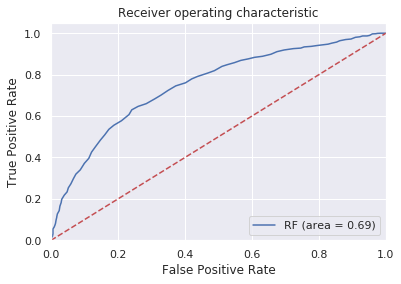

In [61]:
# ROC 
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RF (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
# plt.show()

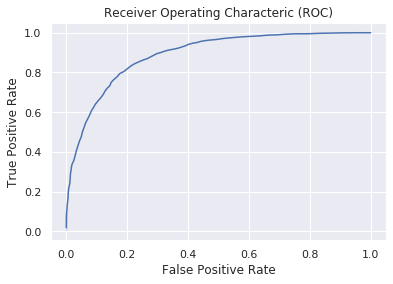

In [35]:
d = {'False Positive Rate': fpr, 'True Positive Rate': tpr}
df = pd.DataFrame(d)
sns.set(style='darkgrid')
sns_plot = sns.lineplot(x='False Positive Rate', y='True Positive Rate', data=df).set_title("Receiver Operating Characteric (ROC)")
# sns_plot.text(0.85, 0.85,'Text Here', fontsize=9) 
sns_plot.figure.savefig("output.png")


In [36]:
# Computing feature_importances 
feature_importances = pd.DataFrame(rf.feature_importances_,index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

In [60]:
feature_importances = feature_importances.groupby([s.split('_')[0] for s in feature_importances.index.values]).sum()
feature_importances = feature_importances.sort_values('importance', ascending = False)
feature_importances.to_excel('Feature_Importances.xlsx')
feature_importances

,importance
Customer ID,0.150940
Material Number,0.112003
Product Family,0.096329
Annual units,0.073983
Monthly units,0.073824
Bid Submitted Month,0.071915
Customer Supply Start date,0.051064
Contract Status,0.042193
Forecast,0.039226
Bid Submitted Date,0.037099


In [38]:
# K-Fold cross-validation 
kf = KFold(n_splits=5) #KFold with k = 5
scores = []
for train_index, test_index in kf.split(df_X):
    X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
    y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    rf.fit(X_train, y_train.values.ravel())
    scores.append(rf.score(X_test, y_test))
print(scores) 

[0.6965305226174792, 0.6732542819499341, 0.7127799736495388, 0.7053140096618358, 0.6903820816864296]


In [59]:
sum = 0
avg = 0
for i in scores:
    sum += i 
avg = (sum/5.0) 
print('Accuracy of RF classifier with 5-fold Cross-Validation: {:.2f}'.format(avg))

Accuracy of RF classifier with 5-fold Cross-Validation: 0.70
